# ReAct Agent

### ChatModel

In [1]:
import os
from langchain_openai import ChatOpenAI

AVALAI_BASE_URL = "https://api.avalai.ir/v1"
GPT_MODEL_NAME = "gpt-4o-mini"

gpt4o_chat = ChatOpenAI(model=GPT_MODEL_NAME,
                        base_url=AVALAI_BASE_URL,
                        api_key=os.environ["AVALAI_API_KEY"])

### Tools

In [2]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

### Search Tool

In [3]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults

def search_tool(query: str):
    """Search the web for the query.
    Args:
        query: The query to search for.
    """
    print("-----------SEARCHING Tool----------")
    print("searching for", query)
    results = TavilySearchResults(max_results=3).invoke(query)
    print("results", results)
    return results

### Bind ChatModel with Tools

In [4]:
tools = [add, multiply, divide, search_tool]
llm_with_tools = gpt4o_chat.bind_tools(tools)

### Define State

In [6]:
from langgraph.graph import MessagesState

### Define Nodes

In [7]:
from langchain_core.messages import HumanMessage, SystemMessage
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

def reasoner(state: MessagesState):
    print("-------------Reasoner----------------")
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    print("Response: ")
    print(response)
    return {"messages": [response]}

### Langgraph 'ToolNode' and 'tools_condition'

In [8]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

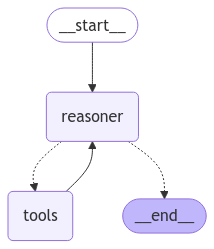

In [9]:
from IPython.display import Image, display

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

### Run Agent

In [10]:
messages = [HumanMessage(content="What is 2 times Milad Mohammadi's age?")]
messages = react_graph.invoke({"messages": messages})

-------------Reasoner----------------
Response: 
content='' additional_kwargs={'tool_calls': [{'id': 'call_MdC2nl0YSOuepU6UH2Pv39IL', 'function': {'arguments': '{"query":"Milad Mohammadi age"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 172, 'total_tokens': 191, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-b7c91fb5-1dae-43b6-9a8f-3ff451e3c0e1-0' tool_calls=[{'name': 'search_tool', 'args': {'query': 'Milad Mohammadi age'}, 'id': 'call_MdC2nl0YSOuepU6UH2Pv39IL', 'type': 'tool_call'}] usage_metadata={'input_tokens': 172, 'output_tokens': 19, 'total_tokens': 191, 'input_token_details': {'audio': 0, 'ca

In [11]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times Milad Mohammadi's age?
================================== Ai Message ==================================
Tool Calls:
  search_tool (call_MdC2nl0YSOuepU6UH2Pv39IL)
 Call ID: call_MdC2nl0YSOuepU6UH2Pv39IL
  Args:
    query: Milad Mohammadi age
================================= Tool Message =================================
Name: search_tool

[{"url": "https://www.transfermarkt.com/milad-mohammadi/profil/spieler/333355", "content": "Milad Mohammadi - Player profile 24/25 | Transfermarkt Player agents Most valuable players in the world Player agents 4 Milad Mohammadi Position: Left-Back Player data Left-Back Name in home country: ميلاد محمدی کشمرزی Date of birth/Age: Sep 29, 1993 (31) Place of birth: Tehran     Height: 1,78 m Citizenship:     Iran Position: Defender - Left-Back Foot: left Player agent: Relatives Current club: Persepolis FC Joined: Aug 19, 2024 Contract expires: Jun 30, 2026 Soc

### Memory Problem

In [12]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

-------------Reasoner----------------
Response: 
content='Could you please provide the number you would like to multiply by 2?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 165, 'total_tokens': 181, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'finish_reason': 'stop', 'logprobs': None} id='run-7d09597a-f751-462b-8280-f34dfbceac70-0' usage_metadata={'input_tokens': 165, 'output_tokens': 16, 'total_tokens': 181, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ======================

### Memory

In [13]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

### Usuing Memory Saver

In [14]:
messages = [HumanMessage(content="What is 2 times Milad Mohammadi's age?")]
messages = react_graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

-------------Reasoner----------------
Response: 
content='' additional_kwargs={'tool_calls': [{'id': 'call_9alAMuFKWMMH6uoBo3BBUyQj', 'function': {'arguments': '{"query":"Milad Mohammadi age 2023"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 172, 'total_tokens': 194, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-6ac72152-33fa-4f29-96c0-185298ea21fb-0' tool_calls=[{'name': 'search_tool', 'args': {'query': 'Milad Mohammadi age 2023'}, 'id': 'call_9alAMuFKWMMH6uoBo3BBUyQj', 'type': 'tool_call'}] usage_metadata={'input_tokens': 172, 'output_tokens': 22, 'total_tokens': 194, 'input_token_details': {'audi

In [16]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

SyntaxError: invalid syntax (2230136041.py, line 2)